In [120]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))
os.getcwd()

'/Users/leahwasser/earth-analytics/data'

In [3]:
# Open fire boundary
fire_boundary_path = "cold-springs-fire/vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp"
fire_boundary = gpd.read_file(fire_boundary_path)

In [4]:
# PRE DATA: .2016191073856_sur_refl_b02_1 the data that i'm looking for 
# POST DATA: 006.2016201065406_sur_refl_b04_1

pre_fire_path = "cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf"
post_fire_path = "cold-springs-fire/modis/17-july-2016/MOD09GA.A2016199.h09v05.006.2016201065406.hdf"

Using MODIS MOD09GA data

Resources
https://www.nceas.ucsb.edu/~pau/StephanieSite/Home_files/MODIS_LP_QA_Tutorial-1.pdf

pymasker (broken but a good guide)
pymodis -- doesn't handle all products
pyhdf -- i haven't tried this yet

it seems like we want to use the 1k QA for the MOD09GA product and then sample it down to 500m using rasterio for the final mask application. Neither of these steps are difficult or complex.  


In [25]:
with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:num_observations_1km
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:granule_pnt_1
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:num_observations_500m
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1
HDF4_EOS:EOS_GRID:cold-springs-fire/modis/07-

Note that rasterio does handle sub datasets.
It is import to read each array as a 2 dim arr to make for easier plotting after the data are stacked. 


https://lpdaac.usgs.gov/documents/306/MOD09_User_Guide_V6.pdf   see tables 11 and 13 for the 

In [90]:
bit_pos = 0
bit_len = 2
value = '00'

# This is pulled from the pymasker package. 
# the first two "slots" or bits are the ones which represent image quality in modis
# I think we could improve this function significantly and add it to earthpy
# i'd like to test the outputs here however against the outputs of the MODIS package for R.

def get_mask(band_data, bit_pos, bit_len, value):
    '''Generates mask with given bit information.

    Parameters
        band data -- numpy array
        bit_pos		-	Position of the specific QA bits in the value string.
        bit_len		-	Length of the specific QA bits.
        value  		-	A value indicating the desired condition.
    '''
    bitlen = int('1' * bit_len, 2)

    if type(value) == str:
        value = int(value, 2)

    pos_value = bitlen << bit_pos
    con_value = value << bit_pos
    mask = (band_data & pos_value) == con_value

    return mask.astype(int)



In [ ]:
data

#np.unpackbits(data)
# This is a way to fully unpack the bits. the above seems a bit better of an approach?
def unpackbits(x, num_bits):
  xshape = list(x.shape)
  x = x.reshape([-1, 1])
  to_and = 2**np.arange(num_bits).reshape([1, num_bits])
  return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])


#test = unpackbits(data, 32)
test.shape, data.shape

qc_layer

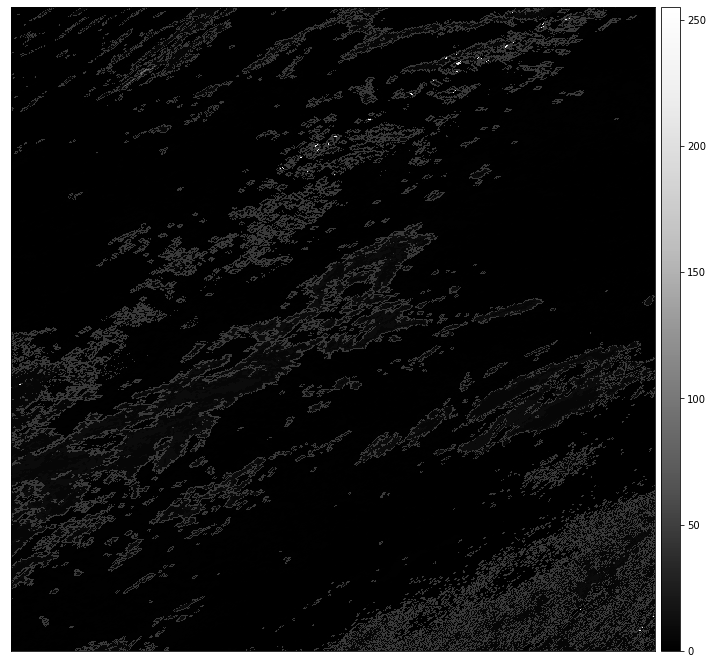

In [119]:
qa_layer_name = "state_1km_1"

with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        # Build out content on regex
        if re.search(qa_layer_name, name):
            with rio.open(name) as subdataset:
                # This is not ideal because it's reprojecting each time... 
                modis_meta = subdataset.profile
                # read in the data as a 2 dim vs 3 dim arr
                qa_data = subdataset.read(1)
# This is the qa data
qa_data

qa_mask = get_mask(qa_data, 0,2,'00')
# Now we need to resample the data -- I think we can do that with rasterio
# We could use another product if one exists in the same resolution as the data??

qa_mask.shape

ep.plot_bands(qa_data)

In [116]:
# With resampling - i took this from the rasterio docs
from rasterio.enums import Resampling

with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        # Build out content on regex
        if re.search(qa_layer_name, name):
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                # read in the data as a 2 dim vs 3 dim arr
                # i think below it's using still a 3 dim but read(1) is preferred.
                # i think count needs to be removed
                qa_data = subdataset.read(1,
                                          out_shape=(
                                              subdataset.height * 2,
                                              subdataset.width * 2),
                                          resampling=Resampling.bilinear)
                
                
qa_data.shape

# Get just the bands into an array


(2400, 2400)

In [127]:
# Get the data -- stack

all_bands = []
# Just get the reflectance data - the bands
with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        # Build out content on regex
        if re.search("b0.\_1$", name):
            with rio.open(name) as subdataset:
                # This is not ideal because it's reprojecting each time... 
                fire_bound_sin = fire_boundary.to_crs(subdataset.crs)
                modis_meta = subdataset.profile
                crop_band, crop_meta = es.crop_image(subdataset, fire_bound_sin)
                # read in the data as a 2 dim vs 3 dim arr
                #all_bands.append(subdataset.read(1))
                all_bands.append(np.squeeze(crop_band))
 
pre_fire_modis = np.stack(all_bands)   
extent_modis_pre = plotting_extent(pre_fire_modis[0], crop_meta["transform"])
pre_fire_modis.shape

/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<autho

(7, 3, 8)

In [128]:

# We may need to transpose the data for this to work looking at the error below
# I think we should at a minimum test for this in mask and return a friendlier error...
# Mask the data
em.mask_pixels(pre_fire_modis, mask_arr=qa_mask)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (1200,1200) and requested shape (7,3,8)

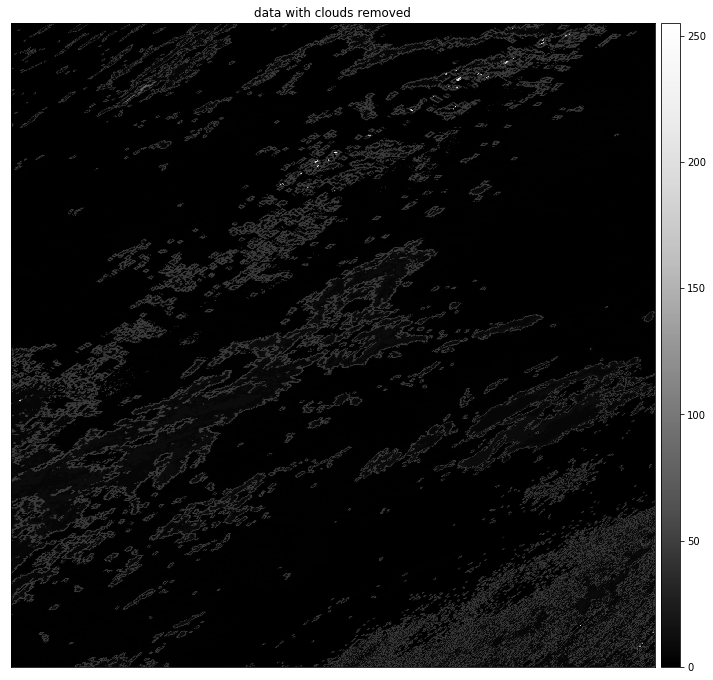

In [118]:
# Quick plot
ep.plot_bands(qa_data, title="data with clouds removed")

In [26]:
all_bands = []
# Just get the reflectance data - the bands
with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        #print(name)
        all_bands.append(name)
   
# Get the QA Layer path manually
qc_layer = all_bands[10]

with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        # Build out content on regex
        if re.search("QC_500m_1", name):
            with rio.open(name) as subdataset:
                # This is not ideal because it's reprojecting each time... 
                modis_meta = subdataset.profile
                #crop_band, crop_meta = es.crop_image(subdataset, fire_bound_sin)
                # read in the data as a 2 dim vs 3 dim arr
                data = subdataset.read(1)
np.unique(data)

np.unpackbits(data)

TypeError: Expected an input array of unsigned byte data type

In [123]:
## Import the data using rasterio
# this could easily become a helper function -- assuming the students needed to import multiple datasets

all_bands = []
# Just get the reflectance data - the bands
with rio.open(pre_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        # Build out content on regex
        if re.search("b0.\_1$", name):
            with rio.open(name) as subdataset:
                # This is not ideal because it's reprojecting each time... 
                fire_bound_sin = fire_boundary.to_crs(subdataset.crs)
                modis_meta = subdataset.profile
                crop_band, crop_meta = es.crop_image(subdataset, fire_bound_sin)
                # read in the data as a 2 dim vs 3 dim arr
                #all_bands.append(subdataset.read(1))
                all_bands.append(np.squeeze(crop_band))
 
pre_fire_modis = np.stack(all_bands)   
extent_modis_pre = plotting_extent(pre_fire_modis[0], crop_meta["transform"])

all_bands = []
# Just get the reflectance data - the bands
with rio.open(post_fire_path) as dataset:
    #crs = dataset.read_crs()
    for name in dataset.subdatasets:
        if re.search("b0.\_1$", name):
            with rio.open(name) as subdataset:
                # This is not ideal because it's reprojecting each time... 
                fire_bound_sin = fire_boundary.to_crs(subdataset.crs)
                modis_meta = subdataset.profile
                crop_band, crop_meta = es.crop_image(subdataset, fire_bound_sin)
                # read in the data as a 2 dim vs 3 dim arr
                #all_bands.append(subdataset.read(1))
                all_bands.append(np.squeeze(crop_band))
 
post_fire_modis = np.stack(all_bands)   
extent_modis_post = plotting_extent(post_fire_modis[0], crop_meta["transform"])

/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/leahwasser/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<autho

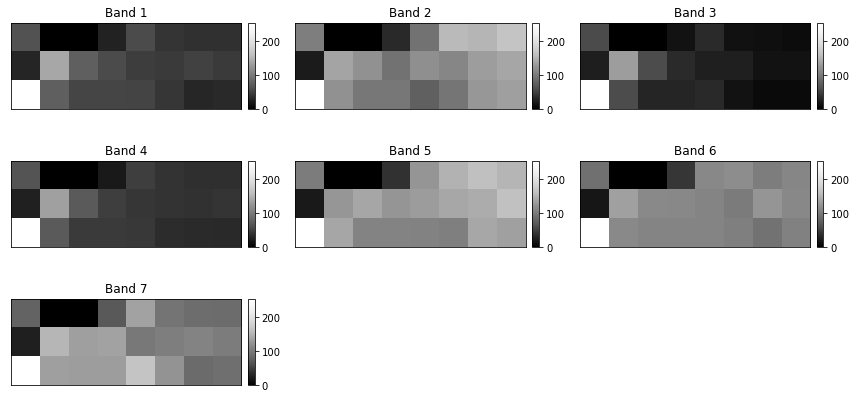

In [36]:
# Plot the data
ep.plot_bands(post_fire_modis, figsize=(12,6))
plt.show()

This is the same answer that we have on the homeworks i believe!


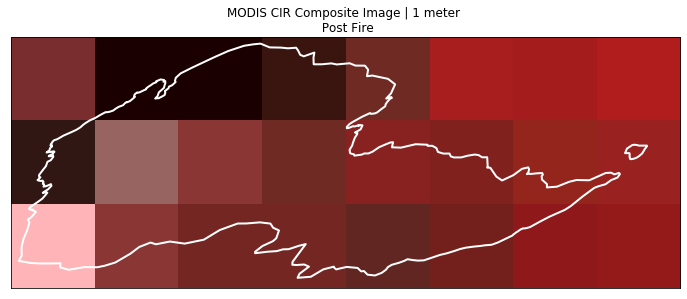

In [37]:
# The data here look DIFFERENT from the homework. look into this more closely
# It's actually the pre-fire data... process the post fire data next
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(post_fire_modis, ax=ax,
            rgb=[1, 0, 3], 
            extent=extent_modis_post,
            title="MODIS CIR Composite Image | 1 meter \n Post Fire")
fire_bound_sin.plot(ax=ax, color='None',
                         edgecolor='white', linewidth=2)

In [7]:
# Open the data using GDAL 
pre_fire_modis = gdal.Open("cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf")
#modis_data = gdal.Open("modis-06-july-2016/MOD09GA.A2016188.h09v05.006.2016190063623.hdf")
# for path, desc in modis_data.GetSubDatasets():
#      print(path, "then", desc)

HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b01_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b02_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1
HDF4_EOS:EOS_GRID:"cold-springs-fire/modis/07-july-2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf":MODIS_Grid_500m_2D:sur_refl_b07_1


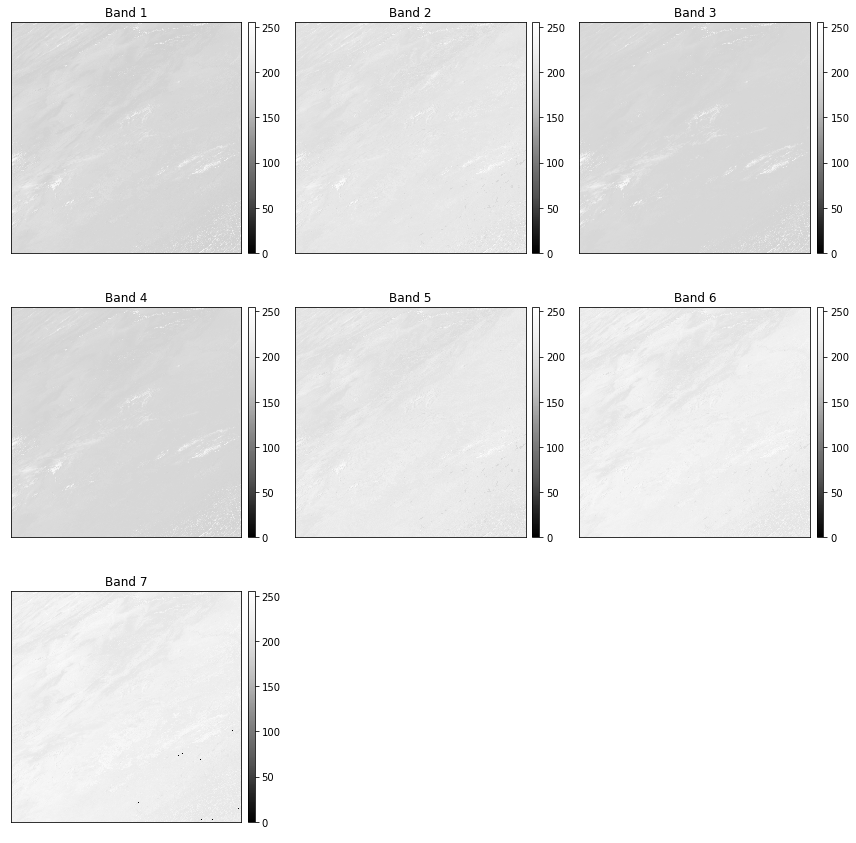

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a5356a0>,
      dtype=object)

In [8]:
# Get reflectance data and stack
path = ''
all_data = []
for data, desc in pre_fire_modis.GetSubDatasets():
    if re.search("b0.\_1$", data):
        print(data)
        band = gdal.Open(data)
        band = band.ReadAsArray()
        all_data.append(band)

all_bands = np.stack(all_data)
ep.plot_bands(all_bands)

In [9]:
# https://towardsdatascience.com/data-analytics-with-modis-data-46338cd6e4d2

def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds
    
# Opens the data HDF file and returns as a dataframe
def read_dataset(SUBDATASET_NAME, FILEPATH):
    dataset = load_data(FILEPATH)
    path = ''
    for sub, description in dataset.GetSubDatasets():
        if (description.endswith(SUBDATASET_NAME)):
            path = sub
            break
    if(path == ''):
        print(SUBDATASET_NAME + ' not found')
        return
    subdataset = gdal.Open(path)
    subdataset = subdataset.ReadAsArray()
    subdataset = pd.DataFrame(subdataset)
return subdataset

SyntaxError: 'return' outside function (<ipython-input-9-5233496129eb>, line 21)